In [1]:
import pandas as pd
import altair as alt
import util
import spacy
import textacy
from tqdm import tqdm
pd.set_option('display.max_colwidth', None)
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

## Comparison of Project Popularity, Open Issues and Forks

In [2]:
pop = util.read_projects()
pop.head()

name  \
0     pytorch   
0  tensorflow   

                                                                  description  \
0  Tensors and Dynamic neural networks in Python with strong GPU acceleration   
0                      An Open Source Machine Learning Framework for Everyone   

               full_name  forks    star            created_at  \
0        pytorch/pytorch  15010   54183  2016-08-13T05:26:41Z   
0  tensorflow/tensorflow  86404  163111  2015-11-07T01:19:20Z   

             updated_at  open_issues  
0  2022-02-24T22:47:20Z        11342  
0  2022-02-24T22:25:18Z         2549

We see that Tensorflow project started in 2016 August, and Pytorch project started 9 months later in August 2016.

In [3]:
a = alt.Chart(pop).mark_bar().encode(
    x='name',
    y='star'
).properties(title='Number of stars', height=300, width=250)

b = alt.Chart(pop).mark_bar().encode(
    x='name',
    y='open_issues:Q'
    
).properties(title='Number of open issues',height=300, width=250)

c = alt.Chart(pop).mark_bar().encode(
    x='name',
    y='forks:Q'
    
).properties(title='Number of forks',height=300, width=250)

a | b | c

alt.HConcatChart(...)

As of February, 2022 Tensorflow has more stars. Pytorch has more than 10,000 open issues! It would be interesting to find out what these open issues are about.

## Tensorflow Issues

In [4]:
tf_issues = util.read_file("data/tensorflow_issues.csv")
tf_issues.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54163 entries, 0 to 54163
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   issue_id    54163 non-null  int64              
 1   user_id     54163 non-null  int64              
 2   created_at  54163 non-null  datetime64[ns, UTC]
 3   closed_at   51614 non-null  object             
 4   title       54161 non-null  object             
 5   state       54163 non-null  object             
 6   labels      37895 non-null  object             
 7   text        50155 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(2), object(5)
memory usage: 3.7+ MB


In [5]:
print(f"Tensorflow Issue length = {len(tf_issues)}, unique issue ids = {len(tf_issues['issue_id'].unique())}")
print(f"Earliest issue created={tf_issues.created_at.min()}")

Tensorflow Issue length = 54163, unique issue ids = 54163
Earliest issue created=2015-11-09 14:21:11+00:00


In [6]:
tf_issues["state"].value_counts()

closed    51614
open       2549
Name: state, dtype: int64

In [7]:
tf_issues.sample(1).T

50533
issue_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

## Pytorch Issues

In [8]:
pt_issues = util.read_file("data/pytorch_issues.csv")
print(f"Pytorch Issue length = {len(pt_issues)}, unique issue ids = {len(pt_issues['issue_id'].unique())}")
print(f"Earliest issue created={pt_issues.created_at.min()}")

Pytorch Issue length = 73251, unique issue ids = 73251
Earliest issue created=2016-08-15 23:01:35+00:00


In [9]:
pt_issues["state"].value_counts()

closed    61905
open      11346
Name: state, dtype: int64

In [10]:
pt_issues.sample(1).T

61622
issue_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        11637
user_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         13564
created_at                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  2018-09-13 13:55:27+00:00
closed_at                                                                                                                                                                                                                                                                               

## Number of Issues per month

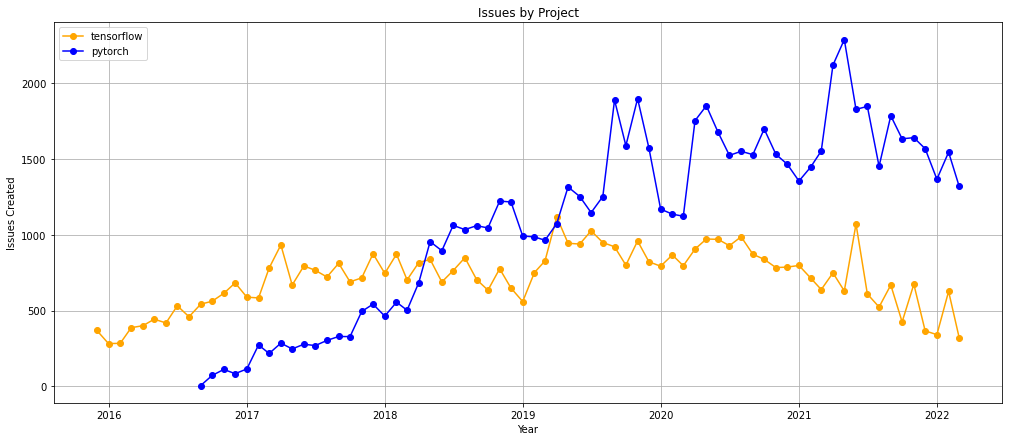

In [11]:
import matplotlib.pyplot as plt
tf_monthly = tf_issues.set_index("created_at").resample('M').agg({"issue_id": "count"})
pt_monthly = pt_issues.set_index("created_at").resample('M').agg({"issue_id": "count"})

fig, ax = plt.subplots(figsize=(17,7))
ax.plot_date(tf_monthly.index,tf_monthly["issue_id"], linestyle ='solid', xdate=True, color="orange", label="tensorflow")
ax.plot_date(pt_monthly.index,pt_monthly["issue_id"], linestyle ='solid', xdate=True, color="blue", label="pytorch")
ax.set_xlabel('Year')
ax.set_ylabel('Issues Created')
ax.set_title('Issues by Project')

plt.gcf().autofmt_xdate
ax.grid(True)
ax.legend(loc="upper left");
plt.savefig('IssuesPerProject.jpg',bbox_inches='tight', dpi=150)

Number of issues for Pytorch project surpassed Tensorflow 2018. This might be due to popularity of the project;perhaps as more people use it, more issues get created. 

## Most Frequent phrases in open issues
I will look at currently open issues and most frequent tokens

In [12]:
tf_open = tf_issues[tf_issues["state"] == "open"][["issue_id", "created_at", "title"]]
pt_open = pt_issues[pt_issues["state"] == "open"][["issue_id", "created_at", "title"]]
display(tf_open.sort_values(by="created_at", ascending=False).head(5).T)
display("-"*20)
display(pt_open.sort_values(by="created_at", ascending=False).head(5).T)

0  \
issue_id                                               54551   
created_at                         2022-02-24 23:37:16+00:00   
title       Add spmd_parameters_shardings to HloModuleProto.   

                                                                        1  \
issue_id                                                            54550   
created_at                                      2022-02-24 23:29:48+00:00   
title       Fixes : https://github.com/tensorflow/tensorflow/issues/54475   

                                                                                                     2  \
issue_id                                                                                         54549   
created_at                                                                   2022-02-24 23:27:45+00:00   
title       Append the path when the metadata was not found to the error message for easier debugging.   

                                            3  \
issue_id                                54548   
created_at          2022-02-24 23:04:04+00:00   
title       Delete another ancient Dockerfile   

                                                                               4  
issue_id                                                                   54547  
created_at                                             2022-02-24 22:51:09+00:00  
title       Remove java-related flags from .bazelrc that are ignored by Bazel 5.

'--------------------'

0  \
issue_id                                                                                     73408   
created_at                                                               2022-02-25 00:18:58+00:00   
title       [PyTorch] [Model Tracer] Use c10::Synchronized<T> abstraction for mutex protected data   

                                                                                                        1  \
issue_id                                                                                            73407   
created_at                                                                      2022-02-25 00:18:53+00:00   
title       [RFC] Implement c10::Synchronized<T>, a basic error-avoiding synchronization wrapper for data   

                                                                   2  \
issue_id                                                       73406   
created_at                                 2022-02-25 00:13:41+00:00   
title       [fx][acc_tracer] fix defaulted placeholder normalization   

                                                           3  \
issue_id                                               73405   
created_at                         2022-02-25 00:10:16+00:00   
title       [PT-D][FSDP] Implement _clip_grad_norm_ for FSDP   

                                            4  
issue_id                                73404  
created_at          2022-02-24 23:57:56+00:00  
title       Pull request to run CI for #72556

## Preprocess title

In [13]:
tf_open["preprocessed"] = tf_open["title"].map(lambda x: util.prep(x))
pt_open["preprocessed"] = pt_open["title"].map(lambda x: util.prep(x))

## Create columns for extracted nlp

In [14]:
dummy_doc = textacy.make_spacy_doc("dummy text", lang="en_core_web_sm")
columns = [k for k in util.extract_nlp(dummy_doc).keys()]

for col in columns:
    tf_open[col] = None
    pt_open[col] = None
    
display(tf_open.columns)
display(pt_open.columns)

Index(['issue_id', 'created_at', 'title', 'preprocessed', 'lemmas', 'bigrams',
       'noun_noun', 'adj_noun', 'verb_noun'],
      dtype='object')

Index(['issue_id', 'created_at', 'title', 'preprocessed', 'lemmas', 'bigrams',
       'noun_noun', 'adj_noun', 'verb_noun'],
      dtype='object')

In [15]:
def extract_nlp(nlp, df):
    
    batch_size = int(len(df)/10)
    
    for i in tqdm(range(0, len(df), batch_size)):    
        docs = nlp.pipe(df['preprocessed'][i:i+batch_size])    
        for j, doc in enumerate(docs):
            for col, values in util.extract_nlp(doc).items():
                df[col].iloc[i+j] = values

    util.process_spans(df)            

## NLP

In [16]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'lemmatizer'])
extract_nlp(nlp, tf_open)
extract_nlp(nlp, pt_open)
print("Extraction is complete...") 


100%|███████████████████████████████████████████| 11/11 [01:23<00:00,  7.56s/it]


Extraction is complete...


In [17]:
tf_bigrams=util.compute_df_idf(tf_open, "noun_noun", min_freq=1)
tf_bigrams = tf_bigrams.drop("__").sort_values(by="df", ascending=False).reset_index().head(20)

In [18]:
pt_bigrams=util.compute_df_idf(pt_open, "noun_noun", min_freq=1)
pt_bigrams = pt_bigrams.drop("__").sort_values(by="df", ascending=False).reset_index().head(20)

In [19]:
a = alt.Chart(tf_bigrams).mark_bar().encode(
    alt.X('df:Q', axis=alt.Axis(title="document frequency")),
    alt.Y('noun_noun:N', sort='-x', axis=alt.Axis(title="phrase"))
).properties(title='Top 20 phrases Tensorflow', height=400, width=500)

b = alt.Chart(pt_bigrams).mark_bar().encode(
    alt.X('df:Q', axis=alt.Axis(title="document frequency")),
    alt.Y('noun_noun:N', sort='-x', axis=alt.Axis(title="phrase"))    
).properties(title='Top 20 phrases Pytorch',height=400, width=500)
    

a & b 

alt.VConcatChart(...)

## Write tokenized issues for further analysis

In [20]:
tf_open.head()

issue_id                created_at  \
0     54551 2022-02-24 23:37:16+00:00   
1     54550 2022-02-24 23:29:48+00:00   
2     54549 2022-02-24 23:27:45+00:00   
3     54548 2022-02-24 23:04:04+00:00   
4     54547 2022-02-24 22:51:09+00:00   

                                                                                        title  \
0                                            Add spmd_parameters_shardings to HloModuleProto.   
1                               Fixes : https://github.com/tensorflow/tensorflow/issues/54475   
2  Append the path when the metadata was not found to the error message for easier debugging.   
3                                                           Delete another ancient Dockerfile   
4                        Remove java-related flags from .bazelrc that are ignored by Bazel 5.   

                                                                                preprocessed  \
0                                            add spmd_parameters_shardings to hlomoduleproto   
1                                                                                fixes : url   
2  append the path when the metadata was not found to the error message for easier debugging   
3                                                          delete another ancient dockerfile   
4                        remove java-related flags from .bazelrc that are ignored by bazel 5   

                                                            lemmas  \
0                  [add, spmd_parameters_sharding, hlomoduleproto]   
1                                                       [fix, url]   
2  [append, path, metadata, find, error, message, easy, debugging]   
3                                    [delete, ancient, dockerfile]   
4            [remove, java, relate, flag, .bazelrc, ignore, bazel]   

                                 bigrams        noun_noun  \
0        [add spmd_parameters_shardings]               []   
1                                     []               []   
2      [error message, easier debugging]  [error message]   
3                   [ancient dockerfile]               []   
4  [remove java, related flags, bazel 5]               []   

               adj_noun                        verb_noun  
0                    []  [add spmd_parameters_shardings]  
1                    []                               []  
2    [easier debugging]                               []  
3  [ancient dockerfile]                               []  
4                    []     [remove java, related flags]

In [21]:
tf_open.to_csv("tf_tokenized.csv", index=False)
pt_open.to_csv("pt_tokenized.csv", index=False)